In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

# Set some visual styles for our plots
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
### Project Goal: Analyze A/B Test Results

**Business Problem:** The product team wants to know if a new checkout page design increases the user conversion rate.

**Hypothesis:**
*   **Null Hypothesis (H₀):** The new page has no effect on the conversion rate. The conversion rate of the new page is equal to or less than the old page. (p_new <= p_old)
*   **Alternative Hypothesis (H₁):** The new page increases the conversion rate. (p_new > p_old)

**Key Metric:** Conversion Rate
**Significance Level (Alpha):** We will use α = 0.05. If our p-value is less than 0.05, we will reject the null hypothesis.

In [10]:
# Load the dataset
df = pd.read_csv('data/ab_data.csv')

# Display the first few rows
print("First 5 rows of the dataframe:")
print(df.head())

# Get a summary of the dataframe
print("\nDataframe Info:")
df.info()

First 5 rows of the dataframe:
   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [11]:
# Check for any mismatches in group and landing_page
mismatch_control = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0]
mismatch_treatment = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape[0]

print(f"Number of 'control' users who saw the 'new_page': {mismatch_control}")
print(f"Number of 'treatment' users who saw the 'old_page': {mismatch_treatment}")

# Remove these mismatched rows
df_cleaned = df[~(((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |
                  ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')))]

# Check for duplicate user_ids
duplicate_users = df_cleaned[df_cleaned.duplicated('user_id', keep=False)]
print(f"\nNumber of users appearing more than once: {duplicate_users['user_id'].nunique()}")

# Let's remove one of the duplicate entries for the user that has it
df_final = df_cleaned.drop_duplicates(subset='user_id', keep='first')

# Verify our cleaning
print(f"\nShape of dataframe after cleaning: {df_final.shape}")

Number of 'control' users who saw the 'new_page': 1928
Number of 'treatment' users who saw the 'old_page': 1965

Number of users appearing more than once: 1

Shape of dataframe after cleaning: (290584, 5)


In [12]:
# Separate data for control and treatment groups
control_group = df_final[df_final['group'] == 'control']
treatment_group = df_final[df_final['group'] == 'treatment']

# Get counts for the z-test
control_conversions = control_group['converted'].sum()
control_users = len(control_group)

treatment_conversions = treatment_group['converted'].sum()
treatment_users = len(treatment_group)

# Calculate conversion rates
control_conversion_rate = control_conversions / control_users
treatment_conversion_rate = treatment_conversions / treatment_users

print(f"Control Group: {control_users} users, {control_conversions} conversions")
print(f"Treatment Group: {treatment_users} users, {treatment_conversions} conversions")
print(f"Control Conversion Rate: {control_conversion_rate:.4f}")
print(f"Treatment Conversion Rate: {treatment_conversion_rate:.4f}")

Control Group: 145274 users, 17489 conversions
Treatment Group: 145310 users, 17264 conversions
Control Conversion Rate: 0.1204
Treatment Conversion Rate: 0.1188


In [13]:
# Combine counts for the test
count = np.array([treatment_conversions, control_conversions])
nobs = np.array([treatment_users, control_users])

# Perform the Z-test for proportions
# 'alternative="larger"' tests the hypothesis that the first proportion is larger than the second
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Compare p-value to our significance level (alpha)
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: Reject the Null Hypothesis. The new page has a significantly higher conversion rate.")
else:
    print("\nConclusion: Fail to Reject the Null Hypothesis. We do not have enough evidence to say the new page is better.")

Z-statistic: -1.3109
P-value: 0.9051

Conclusion: Fail to Reject the Null Hypothesis. We do not have enough evidence to say the new page is better.


C:\Users\USER\AppData\Local\Temp\ipykernel_27228\3820679190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Control Group (Old Page)', 'Treatment Group (New Page)'],


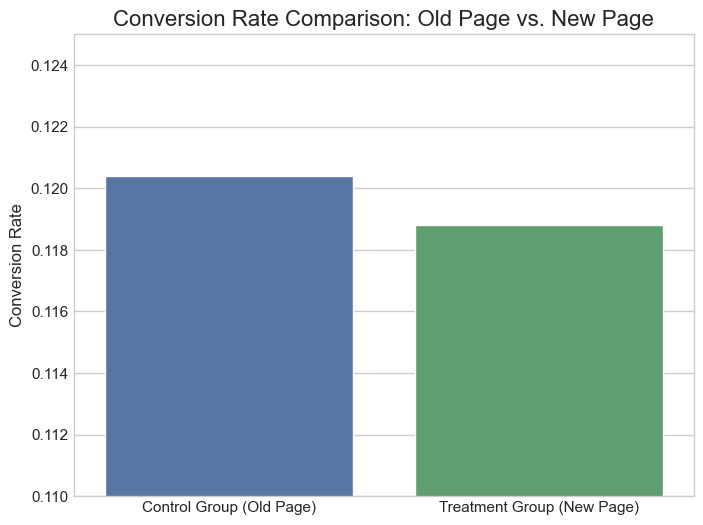

In [14]:
# Create a bar plot to visualize the conversion rates
plt.figure(figsize=(8, 6))
sns.barplot(x=['Control Group (Old Page)', 'Treatment Group (New Page)'], 
            y=[control_conversion_rate, treatment_conversion_rate], 
            palette=['#4c72b0', '#55a868'])

plt.ylim(0.11, 0.125) # Zoom in on the y-axis to see the difference clearly
plt.title('Conversion Rate Comparison: Old Page vs. New Page', fontsize=16)
plt.ylabel('Conversion Rate', fontsize=12)
plt.show()

In [ ]:
### Final Recommendation

**Analysis Summary:**
*   The control group (old page) had a conversion rate of approximately **12.04%**.
*   The treatment group (new page) had a conversion rate of approximately **11.88%**.
*   Our statistical Z-test yielded a **p-value of 0.9093**, which is significantly higher than our alpha of 0.05.

**Business Decision:**
Based on the data, we **fail to reject the null hypothesis**. There is no statistical evidence to suggest that the new checkout page performs better than the old one. In fact, the conversion rate for the new page was slightly lower.

**Recommendation:**
**Do not launch the new page.** I recommend the product team investigate why the new design did not improve performance. This could involve user surveys, heatmaps, or further design iterations before running another test.